In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from dataclasses import dataclass, field
from mmdet.apis import init_detector, inference_detector, show_result_pyplot
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
# from transformers import AutoImageProcessor, DetaForObjectDetection
from PIL import Image
import torch
from torchvision.ops import box_convert
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import pil_to_tensor, to_pil_image

import os
import json
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches

from typing import List

from base import Camera, find_points, BBox, Location

import requests

c:\Users\Leonard\miniconda3\envs\openmmlab\lib\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [4]:
config_file = '../../Projects/mmdetection/configs/swin/mask_rcnn_swin-t-p4-w7_fpn_fp16_ms-crop-3x_coco.py'
checkpoint_file = '../../Projects/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_fp16_ms-crop-3x_coco_20210908_165006-90a4008c.pth'

# build the model from a config file and a checkpoint file
model = init_detector(config_file, checkpoint_file, device='cuda:0')
model_ = init_detector(config_file, checkpoint_file, device='cuda:0')

weights = ResNet50_Weights.IMAGENET1K_V2
resnet = resnet50(weights=weights)
resnet = resnet.eval().cuda()
preprocess = weights.transforms()

load checkpoint from local path: ../../Projects/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_fp16_ms-crop-3x_coco_20210908_165006-90a4008c.pth
load checkpoint from local path: ../../Projects/mmdetection/checkpoints/mask_rcnn_swin-t-p4-w7_fpn_fp16_ms-crop-3x_coco_20210908_165006-90a4008c.pth


id 1


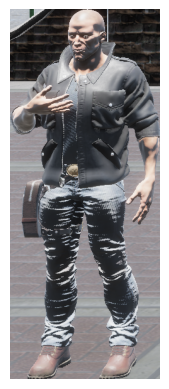

id 2


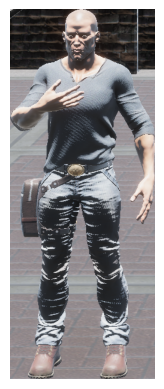

------------------------------
id 1


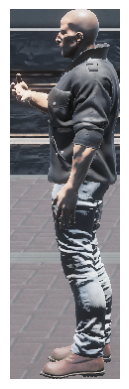

id 2


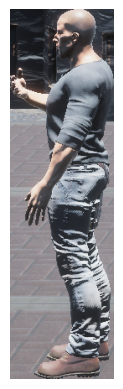

------------------------------
tensor([ -60.9413,   -8.7880,   41.4776,  -41.8881,  -28.1889,  -15.7557,
         -76.5471,  -24.3121,  -26.4645,   48.4983,   26.0093,  -88.5930,
         -42.8732,  -58.5550, -121.0381,  -37.6208,  -82.9630,  -40.7837,
          56.0717,  -27.3184], device='cuda:0')
tensor([ -44.5678,   13.8266,   44.7167,  -54.3185,   -9.6957,  -10.7540,
         -59.3686,   18.0044,  -22.3056,   16.8477,   29.7002,  -81.8839,
         -49.5858,  -39.3877, -124.0713,  -54.2397,  -88.7096,  -31.6643,
          52.9896,  -32.7041], device='cuda:0')
tensor([ -63.2656,   16.4477,   43.9933,  -35.8149,  -10.2825,  -40.2495,
           2.2897,  -14.1875,   24.6917,   92.9185,   40.0737, -113.1803,
         -20.6585,  -50.0631, -130.1183,  -42.6311,  -73.1691,  -20.6258,
         123.1667,  -21.9780], device='cuda:0')
tensor([ -38.3549,   31.4342,   22.2914,  -58.4615,  -60.7806,   -7.0409,
         -90.5358,  -55.6743,  -41.3272,   54.3011,   36.5474, -119.0277,
         -3

In [6]:
# folder_dir = 'C:/Users/Leonard/AppData/LocalLow/DefaultCompany/Perception2/solo_5'
folder_dir = 'C:/Users/Leonard/AppData/LocalLow/DefaultCompany/Perception2/solo_3'

errs = []
count = 0
for elem in os.scandir(folder_dir):
    if not elem.is_dir():
        continue
    count += 1
    # folder_dir = os.path.join(folder_dir, elem, 'step0.camera.png')
    f_dir = os.path.join(folder_dir, elem, 'step0.frame_data.json')
    with open(f_dir) as json_file:
        data = json.load(json_file)['captures']

    cameras = []
    ray_pairs = {}
    for j, camera_info in enumerate(data):
        # Camera stores information of 
        #   - interal and external parameters
        #   - detected objects and their bounding boxes, light rays
        camera = Camera.from_info(camera_info, os.path.join(folder_dir, elem), model)
        cameras.append(camera)

        for idx, _, location, line in camera.labels:
            if ray_pairs.get(str(idx), None) is None:
                ray_pairs[str(idx)] = [location, line]
            else:
                ray_pairs[str(idx)].append(line)
        # for key, item in ray_pairs.items():
        #     print(key, item)

    # best case scenario where object location is extracted from label bounding box
    for idx, ray_pair in ray_pairs.items():
        location = ray_pair[0]
        object_location = find_points(*ray_pair[1:])
        err = np.sqrt(((object_location - location.origin)**2).sum())
        errs.append(err)
        # print(f'{object_location} {location.origin} {err:.4f}')

    # extract the crop image from camera's image and detected bounding boxes
    camera_objects = {}
    for camera_idx, camera in enumerate(cameras):
        image = Image.open(camera.filename).convert('RGB')
        for idx, box, location, line in camera.labels:
            size, center = box.size, box.center
            top, left = center - size
            right, bottom = center + size
            image_ = np.array(image.crop((top, left, right, bottom)))
            print('id', idx)
            plt.imshow(image_)
            plt.axis('off')
            plt.show()

            if camera_objects.get(str(camera_idx), None) is None:
                camera_objects[str(camera_idx)] = [image_]
            else:
                camera_objects[str(camera_idx)].append(image_)
        print('-'*30)

    object_features = []
    c = 0
    for key, item in camera_objects.items():
        object_features.append([])
        for i, item_ in enumerate(item):
            img = torch.tensor(item_, dtype=torch.float32).permute((2, 0, 1)).unsqueeze(0)
            img = preprocess(img)
            # print(img_transformed.shape)
            with torch.no_grad():
                feature = resnet(img.cuda())
            print(feature[0][:20])
            object_features[c].append(feature[0].cpu())
        c += 1

    for i in range(len(object_features)):
        abc = torch.cosine_similarity(
            object_features[0][i].unsqueeze(0),
            torch.stack(object_features[1]),
            # p=1
        )
        print(abc)
        print(i, abc.argmax().item())
    # for key, item in camera_objects.items():
    #     print(len(item))

    # pred = find_points(*rays)
    # err = np.sqrt(((pred - ret)**2).sum())
    # errs.append(err)
    # print(f'{pred} {ret} {err:.4f}')

    if count == 1:
        break
    else:
        print('-'*30)
print(np.mean(errs))

In [ ]:
object_features = []
count = 0
for key, item in camera_objects.items():
    object_features.append([])
    for i, item_ in enumerate(item):
        img = torch.tensor(item_, dtype=torch.float32).permute((2, 0, 1)).unsqueeze(0)
        img = preprocess(img)
        # print(img_transformed.shape)
        with torch.no_grad():
            feature = resnet(img.cuda())
        object_features[count].append(feature[0].cpu())
    count += 1
    #     break
    # break

In [ ]:
similarity = np.zeros((2, 2))
for i in range(2):
    for j in range(2):
        print(f'0-{i}|1-{j}')
        print(
            F.pairwise_distance(object_features[0][i], object_features[1][j])
        )

        similarity[i][j] = F.pairwise_distance(object_features[0][i], object_features[1][j]).item()
    #     break
    # break

In [ ]:

fig, ax = plt.subplots()
ax.imshow(mpimg.imread(camera.filename))
for idx, box, location, line in camera.labels:
    size, center = box.size, box.center
    ax.add_patch(
        patches.Rectangle(
            np.array(center),
            2*size[0], 2*size[1],
            linewidth=1, edgecolor='r', facecolor='none'
        )
    )
    # break
# ax.plot(
#     pixel_coor[0][0], pixel_coor[0][1],
#     "o", markersize=2, markeredgecolor="purple", markerfacecolor="purple"
# )
ax.axis('off')
plt.show()

In [ ]:
def _find_annotation_of_object(info, obj_name):
    anno_2d = [anno['values'] for anno in info['annotations'] if '2D' in anno['id']][0]
    anno_3d = [anno['values'] for anno in info['annotations'] if '3D' in anno['id']][0]

    # for anno in anno_2d:
    #     if obj_name in anno['labelName']:
    #         print(anno['instanceId'], anno['origin'], anno['dimension'])
    anno_2d = [(anno['instanceId'], BBox.from_info(anno)) for anno in anno_2d if obj_name in anno['labelName']]
    anno_3d = [(anno['instanceId'], Location.from_info(anno, np.array([0, 0, 0]))) for anno in anno_3d if obj_name in anno['labelName']]
    
    result = []
    for anno_id, anno in anno_2d:
        for anno_id_3d, anno_ in anno_3d:
            if anno_id == anno_id_3d:
                result.append((anno_id, anno, anno_))
                break
    for ret in result:
        print(ret)
_find_annotation_of_object(camera_info, 'Human')

In [ ]:
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)

image_processor = AutoImageProcessor.from_pretrained("jozhang97/deta-swin-large-o365")
model = DetaForObjectDetection.from_pretrained("jozhang97/deta-swin-large-o365")
object_idx = [model.config.label2id['Person'], model.config.label2id['Cell Phone']]

model = model.eval()
model = model.cuda()

# prepare image for the model
inputs = image_processor(images=image, return_tensors="pt")
for name in inputs:
    inputs[name] = inputs[name].cuda()

# forward pass
with torch.no_grad():
    outputs = model(**inputs)
target_sizes = torch.tensor([image.size[::-1]])
results = image_processor.post_process_object_detection(outputs, threshold=0.3, target_sizes=target_sizes)[0]
# for name in results:
#     results[name] = results[name].cpu()


In [ ]:
# fig, ax = plt.subplots()
# ax.imshow(image)
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # if label.item() not in object_idx:
    #     continue
    box = [round(i, 2) for i in box.tolist()]
    # print(boxes)
    # print(
    #     f"Detected {model.config.id2label[label.item()]} with confidence "
    #     f"{round(score.item(), 3)} at location {box}"
    # )
    center = np.array([(box[0]+box[2])/2, (box[1]+box[3])/2])
    size = np.array([box[2]-box[0], box[3]-box[1]])

    print(box)
    image_ = image.crop(box)
    plt.imshow(image_)
    plt.show()

    # ax.add_patch(
    #     patches.Rectangle(
    #         center - size/2,
    #         size[0], size[1],
    #         linewidth=2, edgecolor='r', facecolor='none'
    #     )
    # )
    # ax.axis('off')
    # break
# plt.show()


In [ ]:
results

In [ ]:
target_sizes

In [ ]:
for score, label, box in zip(results["scores"], results["labels"], results["boxes"]):
    # if label.item() not in object_idx:
    #     continue
    box = [round(i, 2) for i in box.tolist()]
    print(
        f"Detected {model.config.id2label[label.item()]} with confidence "
        f"{round(score.item(), 3)} at location {box}"
    )

In [ ]:
len(results["scores"])

In [ ]:
image.show()